<a href="https://colab.research.google.com/github/oykudenizbozkurt/ECE236A-Project/blob/master/Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [3]:
### MyClassifier Class
class MyClassifier:
    """Main Class for the Project
    
    Attributes:
        y_train: the training data vectors
        s_train: the training data labels
        y_test: the testing data vectors
        s_test: the testting data labels
        
        M: how many dimensions our data input is
            e.g. the MNIST would have 784 as n, as it is a 28x28 image
        N: how many training samples we have
        W: the weight vector [M x 1]
        w: the bias vector [1]
        lambda: a hyperparameter (TODO: tune this)
    
    """
    def __init__(self, M):
        """initializes the data
        arg:
            M: number of features
        """
                      
        # initializing weights
        self.M = M
        self.W = np.zeros(self.M)
        self.w = 0
        # self.lambda = 1e-1

        # initialize empty training set
        self.y_train = np.zeros((0, self.M))
        self.s_train = np.zeros(0, dtype=np.int8)

    def sample_selection(self, training_sample, training_label): # TODO: Is it ok to have training_label as an input to the function? (see project description)
        g_y = training_sample@self.W + self.w
        f_g_y = self.f(g_y)
        
        if g_y == 0 or f_g_y != training_label: # TODO. Current example: g(y) == 0 or classification is wrong
            self.y_train = np.append(self.y_train, [training_sample], axis=0)
            self.s_train = np.append(self.s_train, [training_label], axis=0)
        
        return self

    def train(self, train_data=None, train_label=None):
        '''
        Args:
            train_data: N_train x M
                        M: number of features in data vectors (784) for MNIST
                        N_train: number of points used for training
                        Each row of train_data corresponds to a data point
            train_label: vector of length N_train
        Returns:
            MyClassifier object
        '''
        if train_data is None:
            train_data = self.y_train
        if train_label is None:
            train_label = self.s_train

        # https://www.cvxpy.org/examples/basic/linear_program.html
        N_train = train_data.shape[0]
        Y = train_data
        S = train_label

        if not np.any(S == 1) or not np.any(S == -1):
            return # Do nothing. Need both classes to train effectively

        W = cp.Variable(self.M) # Assumes L = 1
        w = cp.Variable(1)
        t = cp.Variable(N_train)
        prob = cp.Problem(cp.Minimize(np.ones(N_train)@t), [
            np.zeros(N_train) <= t, # 0 <= t_i, i=1,..,N
            1 - (Y[S == 1]@W + w) <= t[S == 1], # 1 - s_i*((W^T)y_i + w) <= t_i
            1 + (Y[S == -1]@W + w) <= t[S == -1]
        ])
        prob.solve()
        # print("\nThe optimal value is", prob.value)
        # print("A solution W, w is")
        # print("W = {}".format(W.value))
        # print("w = {}".format(w.value))

        self.W = W.value
        self.w = w.value
        return self

    def f(self, input):
        '''
        Args:
            input: vector of length L
                   corresponds to the function f(x) = f(g(y))
        Returns:
            estimated class
        '''

        # if abs(input) < 1:
        #     print("Unsure about classification. Value is {}".format(input))

        # decision function in Project Description
        if input > 0:
            return 1
        elif input <= 0:
            return -1

    def test(self, test_data):
        '''
        Args:
            test_data: N_test x M size matrix where
                       M: number of features
                       N_test: number of test data
        Returns:
            vector that contains the classification decisions
        '''
        N_test = test_data.shape[0]

        return np.vectorize(self.f)(test_data@self.W + self.w*np.ones(N_test))

In [4]:
# synthetic dataset
def make_dataset(N):
    Y = np.concatenate((np.random.multivariate_normal(np.array([-1,1]), np.identity(2), N//2), np.random.multivariate_normal(np.array([1,-1]), np.identity(2), N//2)))
    S = np.concatenate((-np.ones(N//2, dtype=np.int8), np.ones(N//2, dtype=np.int8)))
    return (Y, S)

N_train = 1000
N_test = 1000

y_train, s_train = make_dataset(N_train)
y_test, s_test = make_dataset(N_test)

In [8]:
distance.cdist(y_train[s_train==-1],y_train[s_train==-1])

array([[0.        , 1.13456578, 0.30923792, ..., 2.8146313 , 2.49688913,
        1.50620518],
       [1.13456578, 0.        , 1.16911327, ..., 2.36784306, 1.80495111,
        0.41448382],
       [0.30923792, 1.16911327, 0.        , ..., 2.56092115, 2.2993151 ,
        1.4875389 ],
       ...,
       [2.8146313 , 2.36784306, 2.56092115, ..., 0.        , 0.73963217,
        2.11534062],
       [2.49688913, 1.80495111, 2.2993151 , ..., 0.73963217, 0.        ,
        1.48482909],
       [1.50620518, 0.41448382, 1.4875389 , ..., 2.11534062, 1.48482909,
        0.        ]])

In [47]:
#ILP

const = 2
const2 = 35
n = cp.Variable(shape=N_train,integer=True)

dist_neg1 = distance.cdist(y_train[s_train==-1],y_train[s_train==-1])
dist_neg1[dist_neg1==0] = np.amax(dist_neg1,axis=1)

dist_1 = distance.cdist(y_train[s_train==1],y_train[s_train==1])
dist_1[dist_1==0] = np.amax(dist_1,axis=1)

prob = cp.Problem(cp.Minimize(np.ones(N_train)*n),
    [#np.amin(distance.cdist(y_train[s_train==-1],y_train[s_train==1]),axis=1)*n[s_train==-1] <= const,
     #np.amin(distance.cdist(y_train[s_train==1],y_train[s_train==-1]),axis=1)*n[s_train==1] <= const,
     np.amin(dist_neg1,axis=1)*n[s_train==-1] >= const2,
     np.amin(dist_1,axis=1)*n[s_train==1] >= const2,
     n>=0,
     n<=1
     ])


prob.solve()

print("\nThe optimal value is", prob.value)
print("n = {}".format(n.value))

mask = n.value > 0.5

y_new = y_train[mask]
s_new = s_train[mask]
print('y_new = {}'.format(y_new))
print('y_new.shape = {}'.format(y_new.shape))
print('s_new.shape = {}'.format(s_new.shape))


The optimal value is 347.0
n = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 

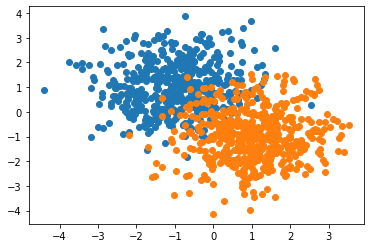

In [ ]:
# Original data
x1 = [val[0] for val in y_train[s_train==-1]]
y1 = [val[1] for val in y_train[s_train==-1]]
plt.scatter(x1, y1)

x2 = [val[0] for val in y_train[s_train==1]]
y2 = [val[1] for val in y_train[s_train==1]]
plt.scatter(x2, y2)

plt.show()

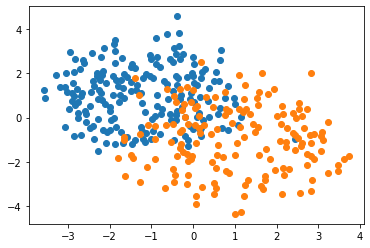

In [48]:
# New data
x1 = [val[0] for val in y_new[s_new==-1]]
y1 = [val[1] for val in y_new[s_new==-1]]
plt.scatter(x1, y1)

x2 = [val[0] for val in y_new[s_new==1]]
y2 = [val[1] for val in y_new[s_new==1]]
plt.scatter(x2, y2)

plt.show()

In [49]:
model = MyClassifier(y_new.shape[1])
model.train(y_new, s_new)

In [50]:
def percentage_correct(inferences, labels):
    N_test = inferences.shape[0]
    return 1/N_test * np.ones(N_test)@(labels == inferences)

In [52]:
inferences = model.test(y_test)
print(percentage_correct(inferences, s_test))

0.9280000000000007
